In [43]:
# 드라이브 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [44]:
from bs4 import BeautifulSoup
from six.moves import urllib

data_dir = '/content/gdrive/My Drive/jena_climate_2009_2016.csv'
urllib.request.urlretrieve('https://raw.githubusercontent.com/gilbutITbook/006975/master/datasets/jena_climate/jena_climate_2009_2016.csv', data_dir )

#파일열기
f = open(data_dir) # 파일 열어서 객체로 정의
data = f.read() # 파일 내용 읽은 객체 정의
f.close # 파일 닫기
#행으로 나누기
lines = data.split('\n')
#헤더 나누기
header = lines[0].split(',')
#나머지 라인 정의하는 객체 생성
lines = lines[1:]
#헤더랑 행 수 프린트
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [0]:
import numpy as np

float_data = np.zeros(shape=(len(lines), len(header)-1))
for i, line in enumerate(lines):
  # .split(' '): 문자열을 나눠서 리스트로 변환
  values = [float(x) for x in line.split(',')[1:]] # line은 문자열이므로, 열을 ','로 구분해야 함
  float_data[i,:]= values

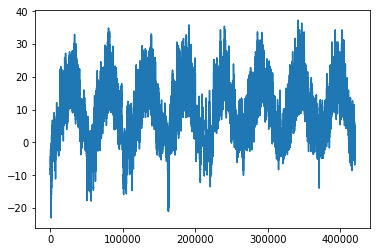

In [0]:
import matplotlib.pyplot as plt
temp = float_data[:,1]
plt.plot(range(len(temp)),temp)
plt.show()



---



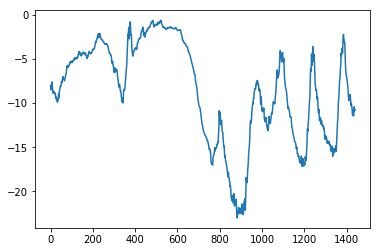

In [0]:
# 10일간 온도
plt.plot(range(len(temp[:1440])), temp[:1440])
plt.show()

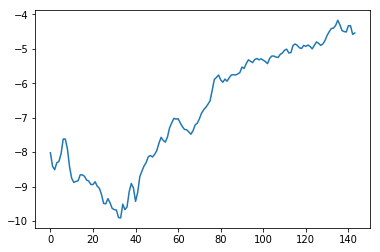

In [0]:
# 하루 온도
plt.plot(range(len(temp[:144])), temp[:144])
plt.show()

In [0]:
# lookback = 1440 : 10일 전으로 돌아가서
# steps = 6 : 한시간마다 데이터 생플링을 함
# delay = 144 : 24시간마다 데이터 타깃
# 1. 데이터 정규화
# 2. 메모리 아끼기 위해 샘플링으로 배치 만들기: 파이썬 제너레이터

In [0]:
# 훈련데이터 [:200000]
# 1. 정규화
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:2000000].std(axis=0)
float_data /= std

In [0]:
# 2. 메모리 아끼기 위해 샘플링으로 배치 만들기: 파이썬 제너레이터
# lookback = 1440 : 10일 전으로 돌아가서
# steps = 6 : 한시간마다 데이터 생플링을 함
# delay = 144 : 24시간마다 데이터 타깃

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size= 128, step= 6):
  if max_index == None:
    max_index = len(data) - delay -1
  i = min_index + lookback
  while 1:
    if shuffle: 
      rows = np.random.randint(min_index+lookback, max_index, size= batch_size)
    else:
      if i + batch_size >= max_index:
         i= min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index)) # i ~ max_index까지 순서대로 숫자 생성
      i += len(rows)
    samples = np.zeros((len(rows), lookback // step, data.shape[-1])) # (128, 10일*시간=240시간, 14)
    targets = np.zeros((len(rows),)) # (128,1)
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [0]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True, # 시간을 섞는다
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size

# 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [0]:
# 상식 수준의 기준점
# 레이블 a가 90%, b가 10%면 최소 90% 이상의 예측 정확도가 나와야 함

# 여기서 평가 기준은 평균 절댓값 오차 MAE = np.mean(np.abs(preds - targets))
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen) # 이터러블 객체에서 다음 값이 나오도록 함
    preds = samples[:,-1,1] # 오늘의 온도
    mae = np.mean(abs(preds-targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()
    

0.3044971244105931


In [0]:
0.3044971244105931 * std[1]

2.5648874349804944

In [0]:
# 기본적인 머신러닝 방법
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
# 시간순이던 배열을 flatten하여 순서 구분 없이 학습하게 됨
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1]))) # (240,14)가 펼처짐
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data= val_gen,
                             validation_steps=val_steps)

W0727 07:47:54.637983 139824315856768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0727 07:47:54.648161 139824315856768 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 17s 34ms/step - loss: 1.0610 - val_loss: 0.4475
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3594 - val_loss: 0.4102
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 0.3031 - val_loss: 0.3369
Epoch 4/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2875 - val_loss: 0.3404
Epoch 5/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2774 - val_loss: 0.3183
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2687 - val_loss: 0.3117
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2632 - val_loss: 0.3475
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2556 - val_loss: 0.3320
Epoch 9/20
500/500 [==============================] - 17s 33ms/step - loss: 0.2521 - val_loss: 0.3359
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.247

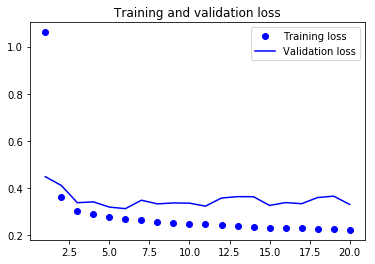

In [0]:
loss = history.history['loss']
val_lose = history.history['val_loss']

epochs = range(1, len(loss) + 1) # range(1,21)= 1~20
plt.figure()
plt.plot(epochs, loss, 'bo',label='Training loss')
plt.plot(epochs, val_lose, 'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# 첫번째 순환신경망
# 시간 순서를 사용
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1]))) # 시간 순서를 펼치지 않음
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0727 07:59:31.772072 139824315856768 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
500/500 [==============================] - 109s 218ms/step - loss: 0.3174 - val_loss: 0.2861
Epoch 2/20
500/500 [==============================] - 108s 217ms/step - loss: 0.3025 - val_loss: 0.2803
Epoch 3/20
500/500 [==============================] - 107s 214ms/step - loss: 0.2959 - val_loss: 0.2789
Epoch 4/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2907 - val_loss: 0.2794
Epoch 5/20
500/500 [==============================] - 109s 218ms/step - loss: 0.2846 - val_loss: 0.2810
Epoch 6/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2815 - val_loss: 0.2822
Epoch 7/20
500/500 [==============================] - 109s 217ms/step - loss: 0.2773 - val_loss: 0.2832
Epoch 8/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2709 - val_loss: 0.2822
Epoch 9/20
500/500 [==============================] - 108s 215ms/step - loss: 0.2682 - val_loss: 0.2848
Epoch 10/20
500/500 [==============================] - 108s 216m

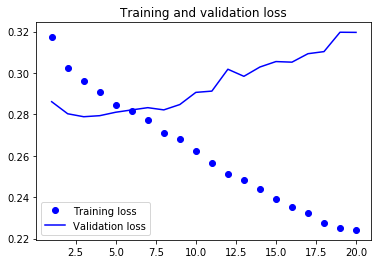

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 188s 377ms/step - loss: 0.3113 - val_loss: 0.2908
Epoch 2/40
500/500 [==============================] - 186s 372ms/step - loss: 0.2898 - val_loss: 0.2830
Epoch 3/40
500/500 [==============================] - 187s 374ms/step - loss: 0.2847 - val_loss: 0.2878
Epoch 4/40
500/500 [==============================] - 188s 377ms/step - loss: 0.2794 - val_loss: 0.2821
Epoch 5/40
500/500 [==============================] - 188s 375ms/step - loss: 0.2744 - val_loss: 0.2812
Epoch 6/40
500/500 [==============================] - 189s 378ms/step - loss: 0.2703 - val_loss: 0.2789
Epoch 7/40
500/500 [==============================] - 189s 378ms/step - loss: 0.2626 - val_loss: 0.2816
Epoch 8/40
500/500 [==============================] - 189s 378ms/step - loss: 0.2574 - val_loss: 0.2914
Epoch 9/40
500/500 [==============================] - 189s 379ms/step - loss: 0.2530 - val_loss: 0.2952
Epoch 10/40
500/500 [==============================] - 189s 377m

KeyboardInterrupt: ignored

#**2. 컨브넷**

### conv1d
(input_feature * kernel_size ) * n_filter + bias * n_filter

ex) (128*7)*32 + 1*32

In [0]:
#@title conv1d
(input_feature * kernel_size + 1) * n_filter
(128*7)*32 + 1*32

In [33]:
from keras.datasets import imdb
from keras.preprocessing import sequence
import numpy as np

max_features = 10000  # 특성으로 사용할 단어의 수
max_len = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)

print('데이터 로드...')
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features) # 리뷰의 개수는 각각 25000개
np.load = np_load_old
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

# 시퀀스 패딩은 배열을 직사각형 모양으로 만들어서 빈칸을 0으로 채우는(패딩하는) 함수
print('시퀀스 패딩 (samples x time)') # sequence_pad = (리뷰 수, 리뷰의 길이)
x_train = sequence.pad_sequences(x_train, maxlen= max_len) #  (훈련 리뷰 수, 리뷰의 길이)
x_test= sequence.pad_sequences(x_test, maxlen= max_len) #  (훈련 리뷰 수, 리뷰의 길이)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import RMSprop

In [37]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length= max_len))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5)) # 각 필터에서 5개 중 가장 큰 놈 뽑는다. 
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D()) # 각 필터 전체에서 가장 큰 값을 가진 원소만 뽑는다.
model.add(Dense(1))

model.summary()

W0728 10:27:55.946737 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 10:27:55.964515 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 10:27:56.035185 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

W0728 10:29:47.464814 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0728 10:29:47.473234 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0728 10:29:47.479558 139735721916288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0728 10:29:47.783770 139735721916288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. P

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.8337 - acc: 0.5091 - val_loss: 0.6874 - val_acc: 0.5664
Epoch 2/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.6699 - acc: 0.6391 - val_loss: 0.6641 - val_acc: 0.6588
Epoch 3/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.6235 - acc: 0.7532 - val_loss: 0.6083 - val_acc: 0.7438
Epoch 4/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.5260 - acc: 0.8077 - val_loss: 0.4847 - val_acc: 0.8062
Epoch 5/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.4115 - acc: 0.8493 - val_loss: 0.4209 - val_acc: 0.8324
Epoch 6/10
20000/20000 [==============================] - 79s 4ms/step - loss: 0.3531 - acc: 0.8694 - val_loss: 0.4144 - val_acc: 0.8368
Epoch 7/10
20000/20000 [==============================] - 80s 4ms/step - loss: 0.3156 - acc: 0.8620 - val_loss: 0.4448 - val_acc:

In [0]:
import matplotlib.pyplot as plt

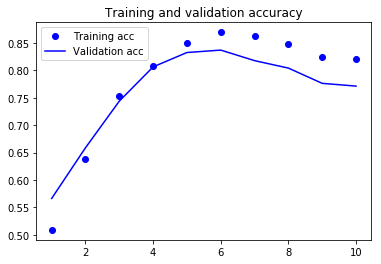

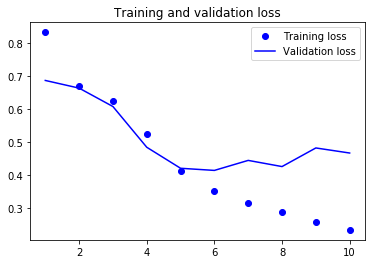

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**CNN과 RNN을 연결하여 긴 시퀀스를 처리하기**

In [49]:
# 위의 온도 예측 문제 적용

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [50]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 46s 93ms/step - loss: 0.4471 - val_loss: 0.4630
Epoch 2/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3930 - val_loss: 0.4593
Epoch 3/20
500/500 [==============================] - 46s 93ms/step - loss: 0.3708 - val_loss: 0.4605
Epoch 4/20
500/500 [==============================] - 47s 93ms/step - loss: 0.3573 - val_loss: 0.4728
Epoch 5/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3482 - val_loss: 0.4788
Epoch 6/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3469 - val_loss: 0.4749
Epoch 7/20
500/500 [==============================] - 46s 93ms/step - loss: 0.3445 - val_loss: 0.4918
Epoch 8/20
500/500 [==============================] - 46s 91ms/step - loss: 0.3515 - val_loss: 0.4689
Epoch 9/20
500/500 [==============================] - 46s 92ms/step - loss: 0.3532 - val_loss: 0.4843
Epoch 10/20
500/500 [==============================] - 46s 93ms/step - loss: 0.370

KeyboardInterrupt: ignored

In [0]:
# conv1D(+풀링) + RNN
# conv가 시퀀스에서 특성을 뽑아내주므로 연산을 줄여주기에, 30분 간격으로 RNN 돌려도 부담 없음
step = 3 # 30분으로 변경
lookback = 1440  # 변경 안 됨
delay = 144 # 변경 안 됨

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [52]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3)) # 대략 3분의 1로 줄어듦
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

W0728 11:39:24.221179 139735721916288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 161s 322ms/step - loss: 0.3607 - val_loss: 0.3008
Epoch 2/20
500/500 [==============================] - 160s 320ms/step - loss: 0.3214 - val_loss: 0.3197
Epoch 3/20
500/500 [==============================] - 160s 319ms/step - loss: 0.3076 - val_loss: 0.2928
Epoch 4/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2984 - val_loss: 0.2858
Epoch 5/20
500/500 [==============================] - 159s 318ms/step - loss: 0.2924 - val_loss: 0.2841
Epoch 6/20
500/500 [==============================] - 160s 320ms/step - loss: 0.2851 - val_loss: 0.3002
Epoch 7/20
 94/500 [====>.........................] - ETA: 1:32 - loss: 0.2803

KeyboardInterrupt: ignored